# Prepare some things
## Load some modules

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras import backend as K
from keras.utils import to_categorical

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
# from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import sklearn.metrics

import pandas as pd
import numpy as np

In [2]:
import sys
sys.path.append('../../')
from models import compute_p, compute_delta, get_dec_model, VaDE, AutoEncoderForPretrain
from clustering_metrics import evaluate_clustering
from draw_embeddings import draw_multiple_labels

In [3]:
# Disable warnings output (TSNE outputs one very time)
import warnings
warnings.filterwarnings('ignore')

## Load the metabolomic data
(already min-max normalized)

In [4]:
metabol_exprs = pd.read_csv("../ExposomeChallengeData/datasets/metabol_joint_exprs_minmax.csv", index_col=0)
metabol_exprs.head()

serum_metab_1  serum_metab_2  serum_metab_3  serum_metab_4  \
430        0.224542       0.205024       0.490470       0.653163   
1187       0.402503       0.549489       0.828354       0.323912   
940        0.402503       0.556896       0.706195       0.534558   
936        0.462293       0.578889       0.451112       0.448921   
788        0.247137       0.571595       0.568414       0.417697   

      serum_metab_5  serum_metab_6  serum_metab_7  serum_metab_8  \
430        0.515652       0.483009       0.249523       0.340524   
1187       0.431621       0.491824       0.376192       0.348330   
940        0.544173       0.514375       0.397976       0.856991   
936        0.492050       0.553183       0.372429       0.544806   
788        0.432269       0.553183       0.531642       0.534388   

      serum_metab_9  serum_metab_10  ...  urine_metab_35  urine_metab_36  \
430        0.400406        0.574663  ...        0.485001        0.628204   
1187       0.213731        0.308797  ...        0.469040        0.816605   
940        0.358113        0.315096  ...        0.469738        0.627037   
936        0.388943        0.545676  ...        0.457602        0.738061   
788        0.536561        0.704749  ...        0.452021        0.639165   

      urine_metab_37  urine_metab_38  urine_metab_39  urine_metab_40  \
430         0.489431        0.640612        0.391376        0.665946   
1187        0.441328        0.000000        0.494475        0.696170   
940         0.519383        0.000000        0.326659        0.645060   
936         0.290234        0.177238        0.451808        0.487007   
788         0.329798        0.354477        0.250210        0.702331   

      urine_metab_41  urine_metab_42  urine_metab_43  urine_metab_44  
430         0.848047        0.360177        0.587031        0.605114  
1187        0.413698        0.396026        0.572658        0.619732  
940         0.841829        0.000000        0.653218        0.665950  
936         0.759121        0.000000        0.678092        0.729031  
788         0.778121        0.345500        0.554585        0.661642  

[5 rows x 221 columns]

In [5]:
metabol_exprs = metabol_exprs.to_numpy()
# np.random.shuffle(metabol_exprs)

In [6]:
num_data_points = np.multiply(*metabol_exprs.shape)
print("Shape of the data set:", metabol_exprs.shape)
print("Number of data points:", num_data_points)

Shape of the data set: (1152, 221)
Number of data points: 254592


## Load the categorical variables
(subset of phenotype and covariates data, already codified)

In [7]:
phenotype_cat = pd.read_csv("../ExposomeChallengeData/datasets/phenotype_cat.csv", index_col=0)
covariates_cat = pd.read_csv("../ExposomeChallengeData/datasets/covariates_cat.csv", index_col=0)
classes = pd.concat([phenotype_cat, covariates_cat], axis=1)
classes.head()

birth_weight  iq  behaviour  asthma  bmi  cohort  age  sex  education  \
1             3   0          3       0    1       3    1    0          1   
2             3   1          3       0    1       3    2    0          2   
3             3   0          3       1    3       3    1    0          2   
4             1   2          3       0    1       1    4    1          0   
5             3   0          1       0    1       2    4    0          0   

   native  parity  
1       2       0  
2       2       1  
3       2       1  
4       2       1  
5       2       0

In [8]:
print("Number of class variables:", classes.shape[1])

Number of class variables: 11


# DC models with 1D convolutional layers

## Prepare the input
- pad with zeros to have shape 224 (divisible by 2 five times)
- add 1 dimention

In [9]:
metabol_exprs = np.pad(metabol_exprs, ((0,0),(0,3)), 'constant', constant_values=0)
metabol_exprs.shape

(1152, 224)

In [10]:
metabol_exprs = np.expand_dims(metabol_exprs, -1)
metabol_exprs.shape

(1152, 224, 1)

## Explore 1D AE hyperparameters

### Construct the model

In [11]:
def get_encoder(input_dim, latent_dim, filters=[], kernel=3):
    encoder_inputs = keras.Input(shape=(input_dim, 1), name="encoder_inputs")
    x = encoder_inputs
    for f in filters:
        x = layers.Conv1D(f, kernel, padding='same', activation="relu") (x)
        x = layers.MaxPool1D(2, padding='same') (x)
    x = layers.Flatten(name="flatten") (x)
    encoder_outputs = layers.Dense(latent_dim, activation="relu", name="z") (x)
    return models.Model(encoder_inputs, encoder_outputs, name="Encoder")
    
def get_decoder(output_dim, latent_dim, filters=[], kernel=3):
    flat_shape = output_dim * filters[-1] // (2*len(filters))
    reshape_shape = (flat_shape//filters[-1], filters[-1])
    
    decoder_inputs = keras.Input(shape=(latent_dim), name="decoder_inputs")
    x = layers.Dense(flat_shape) (decoder_inputs)
    x = layers.Reshape(reshape_shape) (x)
    for f in filters[::-1]:
        x = layers.Conv1DTranspose(f, kernel, strides=2, padding="same") (x)
    decoder_outputs = layers.Conv1D(1, kernel, activation="sigmoid", padding="same", name="recon_x") (x)
    return models.Model(decoder_inputs, decoder_outputs, name="Decoder")

def get_vae_encoder(input_dim, latent_dim, filters=[], kernel=3):
    encoder_inputs = keras.Input(shape=(input_dim, 1), name="encoder_inputs")
    x = encoder_inputs
    for f in filters:
        x = layers.Conv1D(f, kernel, padding='same', activation="relu") (x)
        x = layers.MaxPool1D(2, padding='same') (x)
    x = layers.Flatten(name="flatten") (x)
    z_mu = layers.Dense(latent_dim, name="z_mu") (x)
    z_logvar = layers.Dense(latent_dim, name="z_logvar") (x)
    return models.Model(encoder_inputs, [z_mu, z_logvar], name="Encoder")

In [12]:
INPUT_DIM = metabol_exprs.shape[1]
FILTERS = (4, 16)
LATENT_DIM = 5

encoder = get_encoder(INPUT_DIM, LATENT_DIM, FILTERS)
encoder.summary()

decoder = get_decoder(INPUT_DIM, LATENT_DIM, FILTERS)
decoder.summary()

Model: "Encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_inputs (InputLayer)  [(None, 224, 1)]         0         
                                                                 
 conv1d (Conv1D)             (None, 224, 4)            16        
                                                                 
 max_pooling1d (MaxPooling1D  (None, 112, 4)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 112, 16)           208       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 56, 16)           0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 896)               0   

In [13]:
z = encoder(encoder.inputs)
ae_outputs = decoder(z)
ae = models.Model(encoder.inputs, ae_outputs)
ae.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_inputs (InputLayer)  [(None, 224, 1)]         0         
                                                                 
 Encoder (Functional)        (None, 5)                 4709      
                                                                 
 Decoder (Functional)        (None, 224, 1)            6369      
                                                                 
Total params: 11,078
Trainable params: 11,078
Non-trainable params: 0
_________________________________________________________________


Number of data points / number of parameters ratio:

In [14]:
metabol_exprs.flatten().shape[0] / ae.count_params()

23.293735331287237

### Different kernel sizes

I'll try different numbers of kernel sizes and train an AE multiple times on the metabolomics data, then avarage the results. I'll keep the kernel size that achieves the best relation between data points to parameters ratio and loss result.

In [15]:
INPUT_DIM = metabol_exprs.shape[1]
FILTERS = (4, 16)
LATENT_DIM = 5
KERNELS = (3, 5, 7, 10)

EPOCHS = 50
BATCH_SIZE = 32

LEARNING_RATE = 1
MOMENTUM = 0.8
optimizer = keras.optimizers.SGD(learning_rate=LEARNING_RATE, momentum=MOMENTUM)

for kernel in KERNELS:
    loss = []
    val_loss = []
    loss_ratio = []
    print(f'kernel size: {kernel}', end=" ")
    
    for i in np.arange(10):
        # Construct the autoencoder
        encoder = get_encoder(INPUT_DIM, LATENT_DIM, FILTERS, kernel)
        decoder = get_decoder(INPUT_DIM, LATENT_DIM, FILTERS, kernel)
        z = encoder(encoder.inputs)
        ae_outputs = decoder(z)
        ae = models.Model(encoder.inputs, ae_outputs)
        if i == 0:
            print(f'[data ponints / params ratio: {metabol_exprs.flatten().shape[0] / ae.count_params():.2f}', end=" ")

        # Train it
        ae.compile(optimizer=optimizer, loss="mse")
        history = ae.fit(metabol_exprs, metabol_exprs,
                               epochs=EPOCHS,
                               batch_size=BATCH_SIZE,
                               validation_split=0.2,
                               verbose=0)
        loss.append(history.history['loss'][-1])
        val_loss.append(history.history['val_loss'][-1])
        loss_ratio.append(loss[-1] / val_loss[-1])

    print(f"[loss: {np.mean(loss):.4f}, val_loss: {np.mean(val_loss):.4f}, ratio: {np.mean(loss_ratio):.4f}]")


kernel size: 3 [data ponints / params ratio: 23.29 [loss: 0.0129, val_loss: 0.0138, ratio: 0.9317]
kernel size: 5 [data ponints / params ratio: 21.75 [loss: 0.0132, val_loss: 0.0142, ratio: 0.9288]
kernel size: 7 [data ponints / params ratio: 20.41 [loss: 0.0133, val_loss: 0.0144, ratio: 0.9262]
kernel size: 10 [data ponints / params ratio: 18.67 [loss: 0.0131, val_loss: 0.0141, ratio: 0.9298]


It looks like a kernel size of 3 achieves the best balance.

### Different numbers of filters

Next, I'll try different numbers of filters. I'll keep the encoder and decoder maximum depth to two layers, since adding more layers would increment the number of parameters and we want to keep it low. 

In [16]:
INPUT_DIM = metabol_exprs.shape[1]
LATENT_DIM = 5
KERNEL = 3
FILTERS = ((4,),
           (4, 4),
           (4, 8),
           (4, 16),
           (4, 32),
           (8,),
           (8, 8),
           (8, 16),
           (8, 32),
           (16,),
           (16, 16),
           (16, 32),
           (32,)
          )

EPOCHS = 50
BATCH_SIZE = 32

LEARNING_RATE = 1
MOMENTUM = 0.8
optimizer = keras.optimizers.SGD(learning_rate=LEARNING_RATE, momentum=MOMENTUM)

for f in FILTERS:
    loss = []
    val_loss = []
    loss_ratio = []
    print(f'filter numbers: {f}', end=" ")
    
    for i in np.arange(5):
        # Construct the autoencoder
        encoder = get_encoder(INPUT_DIM, LATENT_DIM, f, KERNEL)
        decoder = get_decoder(INPUT_DIM, LATENT_DIM, f, KERNEL)
        z = encoder(encoder.inputs)
        ae_outputs = decoder(z)
        ae = models.Model(encoder.inputs, ae_outputs)
        if i == 0:
            print(f'[data ponints / params ratio: {metabol_exprs.flatten().shape[0] / ae.count_params():.2f}', end=" ")

        # Train it
        ae.compile(optimizer=optimizer, loss="mse")
        history = ae.fit(metabol_exprs, metabol_exprs,
                               epochs=EPOCHS,
                               batch_size=BATCH_SIZE,
                               validation_split=0.2,
                               verbose=0)
        loss.append(history.history['loss'][-1])
        val_loss.append(history.history['val_loss'][-1])
        loss_ratio.append(loss[-1] / val_loss[-1])

    print(f"[loss: {np.mean(loss):.4f}, val_loss: {np.mean(val_loss):.4f}, ratio: {np.mean(loss_ratio):.4f}]")


filter numbers: (4,) [data ponints / params ratio: 51.47 [loss: 0.0135, val_loss: 0.0145, ratio: 0.9311]
filter numbers: (4, 4) [data ponints / params ratio: 97.23 [loss: 0.0132, val_loss: 0.0141, ratio: 0.9354]
filter numbers: (4, 8) [data ponints / params ratio: 48.09 [loss: 0.0133, val_loss: 0.0143, ratio: 0.9294]
filter numbers: (4, 16) [data ponints / params ratio: 23.29 [loss: 0.0134, val_loss: 0.0144, ratio: 0.9298]
filter numbers: (4, 32) [data ponints / params ratio: 10.91 [loss: 0.0125, val_loss: 0.0136, ratio: 0.9239]
filter numbers: (8,) [data ponints / params ratio: 25.50 [loss: 0.0130, val_loss: 0.0140, ratio: 0.9319]
filter numbers: (8, 8) [data ponints / params ratio: 46.16 [loss: 0.0132, val_loss: 0.0141, ratio: 0.9346]
filter numbers: (8, 16) [data ponints / params ratio: 22.45 [loss: 0.0120, val_loss: 0.0130, ratio: 0.9210]
filter numbers: (8, 32) [data ponints / params ratio: 10.55 [loss: 0.0125, val_loss: 0.0135, ratio: 0.9252]
filter numbers: (16,) [data ponints /

The combinations (4), (4,4), (4, 8) and (8, 8) keep the data points to parameters ratio relatively high while achieving similar performances. Let's try training them fore more epochs to see if the differences get bigger.

In [17]:
INPUT_DIM = metabol_exprs.shape[1]
LATENT_DIM = 5
KERNEL = 3
FILTERS = ((4,),
           (4, 4),
           (4, 8),
           (8,),
           (8, 8),
          )

EPOCHS = 200
BATCH_SIZE = 32

LEARNING_RATE = 1
MOMENTUM = 0.8
optimizer = keras.optimizers.SGD(learning_rate=LEARNING_RATE, momentum=MOMENTUM)

for f in FILTERS:
    loss = []
    val_loss = []
    loss_ratio = []
    print(f'filter numbers: {f}', end=" ")
    
    for i in np.arange(5):
        # Construct the autoencoder
        encoder = get_encoder(INPUT_DIM, LATENT_DIM, f, KERNEL)
        decoder = get_decoder(INPUT_DIM, LATENT_DIM, f, KERNEL)
        z = encoder(encoder.inputs)
        ae_outputs = decoder(z)
        ae = models.Model(encoder.inputs, ae_outputs)
        if i == 0:
            print(f'[data ponints / params ratio: {metabol_exprs.flatten().shape[0] / ae.count_params():.2f}', end=" ")

        # Train it
        ae.compile(optimizer=optimizer, loss="mse")
        history = ae.fit(metabol_exprs, metabol_exprs,
                               epochs=EPOCHS,
                               batch_size=BATCH_SIZE,
                               validation_split=0.2,
                               verbose=0)
        loss.append(history.history['loss'][-1])
        val_loss.append(history.history['val_loss'][-1])
        loss_ratio.append(loss[-1] / val_loss[-1])

    print(f"[loss: {np.mean(loss):.4f}, val_loss: {np.mean(val_loss):.4f}, ratio: {np.mean(loss_ratio):.4f}]")


filter numbers: (4,) [data ponints / params ratio: 51.47 [loss: 0.0129, val_loss: 0.0140, ratio: 0.9232]
filter numbers: (4, 4) [data ponints / params ratio: 97.23 [loss: 0.0127, val_loss: 0.0137, ratio: 0.9245]
filter numbers: (4, 8) [data ponints / params ratio: 48.09 [loss: 0.0126, val_loss: 0.0137, ratio: 0.9224]
filter numbers: (8,) [data ponints / params ratio: 25.50 [loss: 0.0125, val_loss: 0.0136, ratio: 0.9174]
filter numbers: (8, 8) [data ponints / params ratio: 46.16 [loss: 0.0133, val_loss: 0.0143, ratio: 0.9268]


It seems that the simplest configuration (1 convolutional layer with 4 filters) achieves the best loss. It also has one of the best data points to params ratio. I'll use this configuration.

### Selected hyperparameters

I've decided for the following hyperparameters:
- Number of convolutional layers: 1
- Number of filters: 4
- Kernel size: 3

## DEC with 1D convolutional layers

In [18]:
categorical_variables = {2: ["asthma", "sex"],
                         3: ["education", "native", "parity"],
                         4: ["birth_weight", "iq", "behaviour", "bmi"],
                         6: ["cohort"],
                         7: ["age"]}

true_labels = {}
for k, variables in categorical_variables.items():
    true_labels[k] = {var: classes.loc[:,var] for var in variables}

cluster_labels = []
results = []

In [19]:
INPUT_DIM = metabol_exprs.shape[1]
KERNEL = 3
FILTERS = (4,)

EPOCHS_PRETRAIN = 100
LEARNING_RATE_PRETRAIN = 1
MOMENTUM_PRETRAIN = 0.8

EPOCHS_FINETUNE = 100
LEARNING_RATE_FINETUNE = 1e-4
MOMENTUM_FINETUNE = 0.9

BATCH_SIZE = 32
SCHEDULE = 10
DELTA_THRESHOLD = 0.001

In [20]:
def dec_callback(epoch, logs):
    global p
    global c_last
    
    if (epoch+1) % SCHEDULE == 0:
        q = model_dec.soft_assignment(metabol_exprs)
        p = compute_p(q)
        
        c_new = q.numpy().argmax(1)
        delta = compute_delta(c_new, c_last)
        c_last = np.copy(c_new)
        # print(f"Delta: {delta:.3f}")
        if (delta < DELTA_THRESHOLD):
            model_dec.stop_training = True
            
callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=dec_callback)

K=2 - Pretraining AE [loss: 0.0138] - Fine-tunning DEC [loss: 2.4430]
asthma ['Acc: 0.893', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.576']
sex ['Acc: 0.530', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.576']
K=3 - Pretraining AE [loss: 0.0138] - Fine-tunning DEC [loss: 4.1124]
education ['Acc: 0.513', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.474']
native ['Acc: 0.838', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.474']
parity ['Acc: 0.455', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.474']
K=4 - Pretraining AE [loss: 0.0139] - Fine-tunning DEC [loss: 6.0705]
birth_weight ['Acc: 0.274', 'ARI: -0.000', 'AMI: -0.000', 'Sil: 0.381']
iq ['Acc: 0.286', 'ARI: -0.002', 'AMI: -0.001', 'Sil: 0.381']
behaviour ['Acc: 0.269', 'ARI: -0.001', 'AMI: -0.001', 'Sil: 0.381']
bmi ['Acc: 0.694', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.381']
K=6 - Pretraining AE [loss: 0.0126] - Fine-tunning DEC [loss: 8.1808]
cohort ['Acc: 0.214', 'ARI: 0.002', 'AMI: 0.001', 'Sil: 0.301']
K=7 - Pretraining AE [loss: 0.0118] - Fine-tunning DEC [loss: 9.1528]
ag

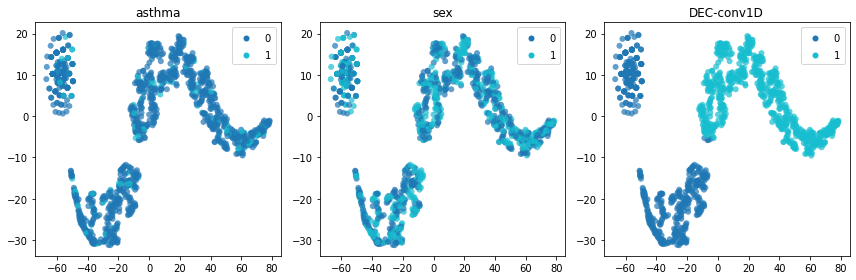

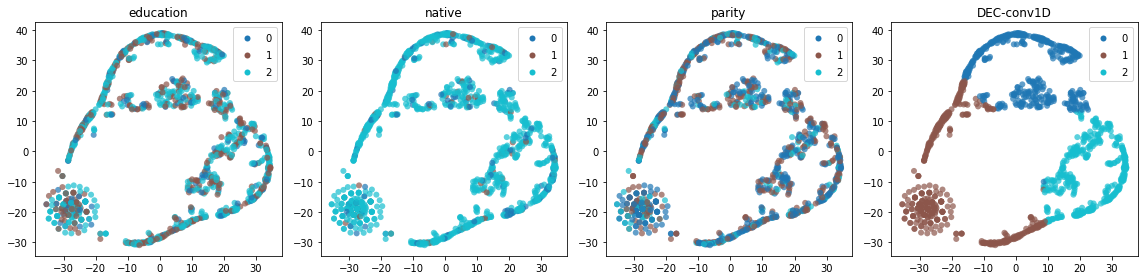

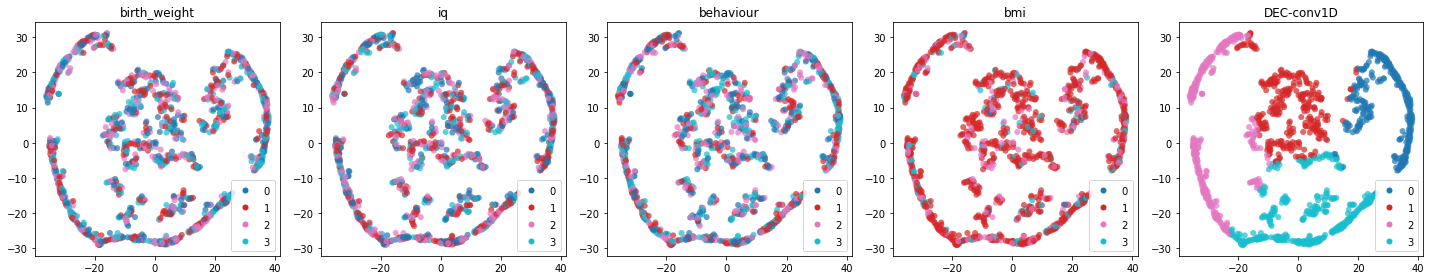

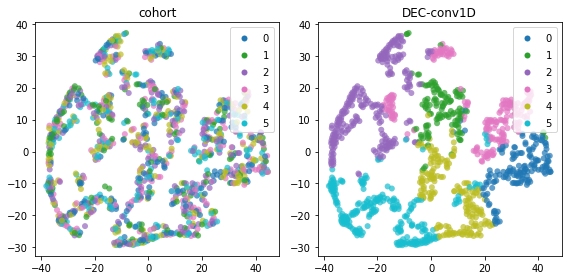

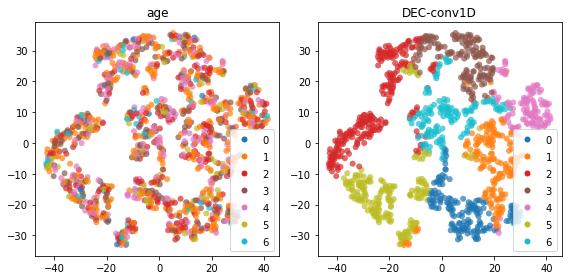

In [21]:
rl_method = "DEC-conv1D"
clust_method = "K-Means"

for k, variables in categorical_variables.items():
    LATENT_DIM = k
    N_CLUSTERS = k
    
    # Construct and pretrain AE
    print(f"K={k} - Pretraining AE", end=" ")
    encoder = get_encoder(INPUT_DIM, LATENT_DIM, FILTERS, KERNEL)
    decoder = get_decoder(INPUT_DIM, LATENT_DIM, FILTERS, KERNEL)
    z = encoder(encoder.inputs)
    ae_outputs = decoder(z)
    model_ae = models.Model(encoder.inputs, ae_outputs)
    
    optimizer = keras.optimizers.SGD(learning_rate=LEARNING_RATE_PRETRAIN,
                                     momentum=MOMENTUM_PRETRAIN)
    loss = "mse"
    model_ae.compile(optimizer=optimizer, loss=loss)
    history = model_ae.fit(metabol_exprs, metabol_exprs,
                           epochs=EPOCHS_PRETRAIN,
                           batch_size=BATCH_SIZE,
                           verbose=0)
    print(f"[loss: {history.history['loss'][-1]:.4f}]", end=" ")
    
    # Construct DEC
    print("- Fine-tunning DEC", end=" ")
    model_dec = get_dec_model(encoder, N_CLUSTERS)
    
    # Initialize parameters
    z_dec = model_dec.encode(metabol_exprs)
    kmeans = KMeans(n_clusters=N_CLUSTERS, n_init=30)
    kmeans.fit(z_dec)
    for weight in model_dec.trainable_weights:
        if weight.name == "centroids:0":
            weight.assign(K.constant(kmeans.cluster_centers_))

    p = compute_p(to_categorical(kmeans.labels_))
    c_last = kmeans.labels_

    # Fine-tune the model
    optimizer = keras.optimizers.SGD(learning_rate=LEARNING_RATE_FINETUNE, 
                                     momentum=MOMENTUM_FINETUNE)
    model_dec.compile(optimizer=optimizer)
    history = model_dec.fit(metabol_exprs, p,
                            epochs=EPOCHS_FINETUNE,
                            batch_size=BATCH_SIZE,
                            callbacks = callback,
                            verbose=0)
    print(f"[loss: {history.history['loss'][-1]:.4f}]")
    
    # Compute the cluster assignments
    c_dec = model_dec.classify(metabol_exprs)
    cluster_labels.append({"rl_method": rl_method, 
                           "clust_method": clust_method, 
                           "n_clusters": k, 
                           "labels": c_dec})
    
    # Compute metrics
    z_dec = model_dec.encode(metabol_exprs)
    for variable, labels in true_labels[k].items():
        metrics = evaluate_clustering(z_dec, labels, c_dec, False)
        print(variable, [f'{metric}: {value:.3f}' for metric, value in metrics.items()])
        result = {"rl_method": rl_method, 
                  "clust_method": clust_method, 
                  "n_clusters": k, 
                  "variable": variable}
        result.update(metrics)
        results.append(result)
    
    # Draw the embeddings
    tsne = TSNE(n_components=2, init='pca')
    z_dec_tsne = tsne.fit_transform(z_dec)

    labels = true_labels[k].copy()
    labels.update({rl_method: c_dec})
    draw_multiple_labels(z_dec_tsne, labels)

## VaDE with 1D convolutional layers

In [22]:
INPUT_DIM = metabol_exprs.shape[1]  # 221
KERNEL = 3
FILTERS = (4,)

EPOCHS_PRETRAIN = 20
LEARNING_RATE_PRETRAIN = 1
MOMENTUM_PRETRAIN = 0.9

EPOCHS_FINETUNE = 100
LEARNING_RATE_FINETUNE = 1e-5
MOMENTUM_FINETUNE = 0.8

BATCH_SIZE = 32
SCHEDULE = 10

In [23]:
def scheduler(epoch, lr):
    if (epoch+1) % SCHEDULE == 0:
        lr = lr * 0.9
    return lr

callback = [tf.keras.callbacks.LearningRateScheduler(scheduler),]

K=2 - Pretraining AE [loss: 0.6385] - Fine-tunning VaDE [loss: 32027.3125]
asthma ['Acc: 0.893', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.358']
sex ['Acc: 0.530', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.358']
K=3 - Pretraining AE [loss: 0.6361] - Fine-tunning VaDE [loss: 31898.9785]
education ['Acc: 0.513', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.222']
native ['Acc: 0.838', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.222']
parity ['Acc: 0.455', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.222']
K=4 - Pretraining AE [loss: 0.6351] - Fine-tunning VaDE [loss: 31812.4375]
birth_weight ['Acc: 0.296', 'ARI: 0.005', 'AMI: 0.005', 'Sil: 0.137']
iq ['Acc: 0.299', 'ARI: 0.000', 'AMI: -0.000', 'Sil: 0.137']
behaviour ['Acc: 0.273', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.137']
bmi ['Acc: 0.694', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.137']
K=6 - Pretraining AE [loss: 0.6320] - Fine-tunning VaDE [loss: 31689.4512]
cohort ['Acc: 0.214', 'ARI: 0.002', 'AMI: 0.003', 'Sil: 0.094']
K=7 - Pretraining AE [loss: 0.6299] - Fine-tunning VaDE [

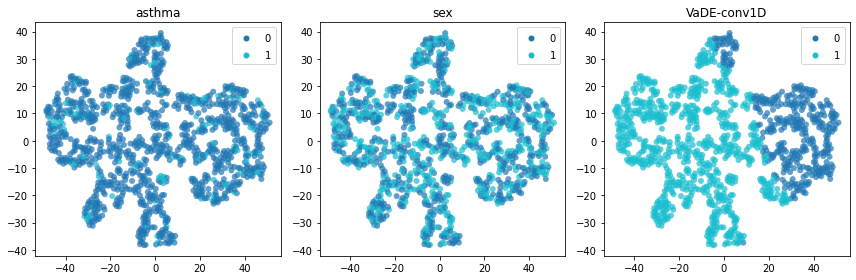

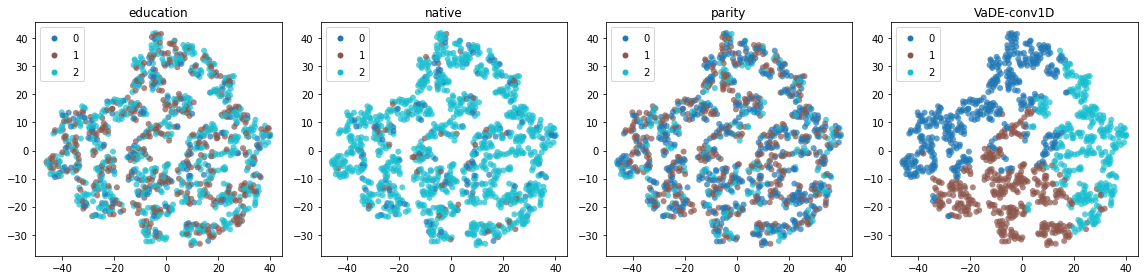

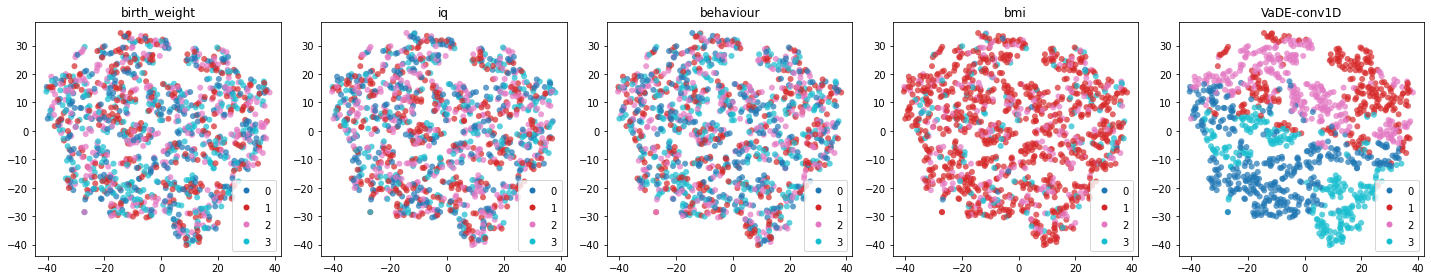

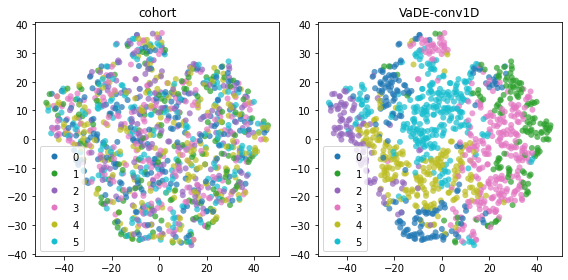

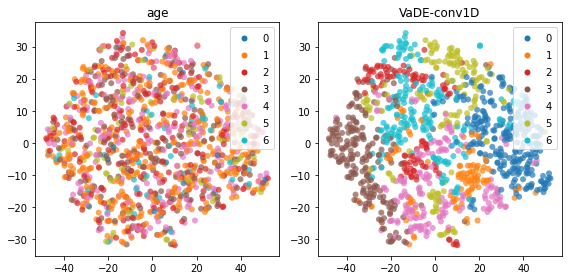

In [24]:
rl_method = "VaDE-conv1D"
clust_method = "GMM"

for k, variables in categorical_variables.items():
    LATENT_DIM = k
    N_CLUSTERS = k
    
    # Construct and train the VaDE model.
    # If loss == NaN: retry.
    while True:
        # Construct and pretrain the AE
        print(f"K={k} - Pretraining AE", end=" ")
        vae_encoder = get_vae_encoder(INPUT_DIM, LATENT_DIM, FILTERS, KERNEL)
        vae_decoder = get_decoder(INPUT_DIM, LATENT_DIM, FILTERS, KERNEL)
        model_pretrain = AutoEncoderForPretrain(vae_encoder, vae_decoder)
        
        optimizer = keras.optimizers.SGD(learning_rate=LEARNING_RATE_PRETRAIN,
                                         momentum=MOMENTUM_PRETRAIN)
        loss = keras.losses.BinaryCrossentropy()
        model_pretrain.compile(optimizer=optimizer, loss=loss)
        history = model_pretrain.fit(metabol_exprs,
                                     epochs=EPOCHS_PRETRAIN,
                                     batch_size=BATCH_SIZE,
                                     verbose=0)
        print(f"[loss: {history.history['loss'][-1]:.4f}]", end=" ")
        
        # Construct the VaDE model
        model_vade = VaDE(N_CLUSTERS, vae_encoder, vae_decoder)
        # Initialize parameters
        z_vade = model_vade.encode_only_mu(metabol_exprs)
        gmm = GaussianMixture(n_components=N_CLUSTERS, covariance_type='diag', n_init=30)
        gmm.fit(z_vade)
        for weight in model_vade.trainable_weights:
            if weight.name == "pi:0":
                weight.assign(K.log(K.constant(gmm.weights_)))
            elif weight.name == "mu:0":
                weight.assign(K.constant(gmm.means_))
            elif weight.name == "logvar:0":
                weight.assign(K.log(K.constant(gmm.covariances_)))

        # Fine-tune the model
        print("- Fine-tunning VaDE", end=" ")
        optimizer = keras.optimizers.SGD(learning_rate=LEARNING_RATE_FINETUNE,
                                         momentum=MOMENTUM_FINETUNE)
        model_vade.compile(optimizer=optimizer)
        history = model_vade.fit(metabol_exprs,
                                 epochs=EPOCHS_FINETUNE,
                                 batch_size=BATCH_SIZE,
                                 callbacks = callback,
                                 verbose=0)
        #If loss == NaN: retry.
        if np.isnan(history.history['loss'][-1]):
            print("[loss:NaN. Retrying.]")
            continue
        else:
            print(f"[loss: {history.history['loss'][-1]:.4f}]")
            break

    # Compute the cluster assignments
    c_vade = model_vade.classify(metabol_exprs).numpy()
    cluster_labels.append({"rl_method": rl_method, 
                           "clust_method": clust_method, 
                           "n_clusters": k, 
                           "labels": c_vade})
    
    # Compute metrics
    z_vade = model_vade.encode_only_mu(metabol_exprs)
    for variable, labels in true_labels[k].items():
        metrics = evaluate_clustering(z_vade, labels, c_vade, False)
        print(variable, [f'{metric}: {value:.3f}' for metric, value in metrics.items()])
        result = {"rl_method": rl_method, 
                  "clust_method": clust_method, 
                  "n_clusters": k, 
                  "variable": variable}
        result.update(metrics)
        results.append(result)
    
    # Draw the embeddings
    tsne = TSNE(n_components=2, init='pca')
    z_vade_tsne = tsne.fit_transform(z_vade)

    labels = true_labels[k].copy()
    labels.update({rl_method: c_vade})
    draw_multiple_labels(z_vade_tsne, labels)

# DC models with 2D convolutional layers

## Prepare the input
- pad with zeros to have shape 256 
- impose a 2D structure by reshaping it to (16, 16) (divisible by 2 three times)
- add 1 dimention

In [25]:
metabol_exprs = pd.read_csv("ExposomeChallengeData/datasets/metabol_joint_exprs_minmax.csv", index_col=0)
metabol_exprs = metabol_exprs.to_numpy()               # (1152, 221)
metabol_exprs = np.pad(metabol_exprs, ((0,0),(18,17)),
                       'constant', constant_values=0)  # (1152, 256)
metabol_exprs = metabol_exprs.reshape(1152, 16, 16)    # (1152, 16, 16)
metabol_exprs = np.expand_dims(metabol_exprs, -1)      # (1152, 16, 16, 1)

## Explore 2D AE hyperparameters

### Construct the models

In [26]:
def get_encoder(input_dim, latent_dim, filters=[], kernel=3):
    encoder_inputs = keras.Input(shape=(input_dim), name="encoder_inputs")
    x = encoder_inputs
    for f in filters:
        x = layers.Conv2D(f, kernel, padding='same', activation="relu") (x)
        x = layers.MaxPool2D(2, padding='same') (x)
    x = layers.Flatten(name="flatten") (x)
    encoder_outputs = layers.Dense(latent_dim, activation="relu", name="z") (x)
    return models.Model(encoder_inputs, encoder_outputs, name="Encoder")
    
def get_decoder(output_dim, latent_dim, filters=[], kernel=3):
    z_res = output_dim[0] // (2*len(filters))
    flat_shape = z_res**2 * filters[-1]
    reshape_shape = (z_res, z_res, filters[-1])
    
    decoder_inputs = keras.Input(shape=(latent_dim), name="decoder_inputs")
    x = layers.Dense(flat_shape) (decoder_inputs)
    x = layers.Reshape(reshape_shape) (x)
    for f in filters[::-1]:
        x = layers.Conv2DTranspose(f, kernel, strides=2, padding="same") (x)
    decoder_outputs = layers.Conv2D(1, kernel, activation="sigmoid", padding="same", name="recon_x") (x)
    return models.Model(decoder_inputs, decoder_outputs, name="Decoder")

def get_vae_encoder(input_dim, latent_dim, filters=[], kernel=3):
    encoder_inputs = keras.Input(shape=(input_dim), name="encoder_inputs")
    x = encoder_inputs
    for f in filters:
        x = layers.Conv2D(f, kernel, padding='same', activation="relu") (x)
        x = layers.MaxPool2D(2, padding='same') (x)
    x = layers.Flatten(name="flatten") (x)
    z_mu = layers.Dense(latent_dim, name="z_mu") (x)
    z_logvar = layers.Dense(latent_dim, name="z_logvar") (x)
    return models.Model(encoder_inputs, [z_mu, z_logvar], name="Encoder")

In [27]:
INPUT_DIM = (16, 16, 1)
FILTERS = (4, 8)
LATENT_DIM = 5

encoder = get_encoder(INPUT_DIM, LATENT_DIM, FILTERS)
encoder.summary()

vae_encoder = get_encoder(INPUT_DIM, LATENT_DIM, FILTERS)
vae_encoder.summary()

decoder = get_decoder(INPUT_DIM, LATENT_DIM, FILTERS)
decoder.summary()

Model: "Encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_inputs (InputLayer)  [(None, 16, 16, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 4)         40        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 8, 8, 4)          0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 8)           296       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 8)          0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 128)               0   

### Different kernel sizes

I'll try different numbers of kernel sizes and train an AE multiple times on the metabolomics data, then avarage the results. I'll keep the kernel size that achieves the best relation between data points to parameters ratio and loss result.

In [28]:
INPUT_DIM = (16, 16, 1)
FILTERS = (4, 8)
LATENT_DIM = 5
KERNELS = (3, 5, 7, 10)

EPOCHS = 50
BATCH_SIZE = 32

LEARNING_RATE = 1
MOMENTUM = 0.8
optimizer = keras.optimizers.SGD(learning_rate=LEARNING_RATE, momentum=MOMENTUM)

for kernel in KERNELS:
    loss = []
    val_loss = []
    loss_ratio = []
    print(f'kernel size: {kernel}', end=" ")
    
    for i in np.arange(10):
        # Construct the autoencoder
        encoder = get_encoder(INPUT_DIM, LATENT_DIM, FILTERS, kernel)
        decoder = get_decoder(INPUT_DIM, LATENT_DIM, FILTERS, kernel)
        z = encoder(encoder.inputs)
        ae_outputs = decoder(z)
        ae = models.Model(encoder.inputs, ae_outputs)
        if i == 0:
            print(f'[data ponints / params ratio: {metabol_exprs.flatten().shape[0] / ae.count_params():.2f}', end=" ")

        # Train it
        ae.compile(optimizer=optimizer, loss="mse")
        history = ae.fit(metabol_exprs, metabol_exprs,
                               epochs=EPOCHS,
                               batch_size=BATCH_SIZE,
                               validation_split=0.2,
                               verbose=0)
        loss.append(history.history['loss'][-1])
        val_loss.append(history.history['val_loss'][-1])
        loss_ratio.append(loss[-1] / val_loss[-1])

    print(f"[loss: {np.mean(loss):.4f}, val_loss: {np.mean(val_loss):.4f}, ratio: {np.mean(loss_ratio):.4f}]")


kernel size: 3 [data ponints / params ratio: 110.79 [loss: 0.0132, val_loss: 0.0139, ratio: 0.9486]
kernel size: 5 [data ponints / params ratio: 60.96 [loss: 0.0124, val_loss: 0.0131, ratio: 0.9498]
kernel size: 7 [data ponints / params ratio: 36.40 [loss: 0.0118, val_loss: 0.0127, ratio: 0.9329]
kernel size: 10 [data ponints / params ratio: 19.61 [loss: 0.0111, val_loss: 0.0120, ratio: 0.9248]


### Different numbers of filters

Next, I'll try different numbers of filters. I'll keep the encoder and decoder maximum depth to two layers, since adding more layers would increment the number of parameters and we want to keep it low. 

In [29]:
INPUT_DIM = (16, 16, 1)
LATENT_DIM = 5
KERNELS = 3
FILTERS = ((4,),
           (4, 4),
           (4, 8),
           (4, 16),
           (4, 32),
           (8,),
           (8, 8),
           (8, 16),
           (8, 32),
           (16,),
           (16, 16),
           (16, 32),
           (32,)
          )

EPOCHS = 50
BATCH_SIZE = 32

LEARNING_RATE = 1
MOMENTUM = 0.8
optimizer = keras.optimizers.SGD(learning_rate=LEARNING_RATE, momentum=MOMENTUM)

for f in FILTERS:
    loss = []
    val_loss = []
    loss_ratio = []
    print(f'filter numbers: {f}', end=" ")
    
    for i in np.arange(5):
        # Construct the autoencoder
        encoder = get_encoder(INPUT_DIM, LATENT_DIM, f, KERNEL)
        decoder = get_decoder(INPUT_DIM, LATENT_DIM, f, KERNEL)
        z = encoder(encoder.inputs)
        ae_outputs = decoder(z)
        ae = models.Model(encoder.inputs, ae_outputs)
        if i == 0:
            print(f'[data ponints / params ratio: {metabol_exprs.flatten().shape[0] / ae.count_params():.2f}', end=" ")

        # Train it
        ae.compile(optimizer=optimizer, loss="mse")
        history = ae.fit(metabol_exprs, metabol_exprs,
                               epochs=EPOCHS,
                               batch_size=BATCH_SIZE,
                               validation_split=0.2,
                               verbose=0)
        loss.append(history.history['loss'][-1])
        val_loss.append(history.history['val_loss'][-1])
        loss_ratio.append(loss[-1] / val_loss[-1])

    print(f"[loss: {np.mean(loss):.4f}, val_loss: {np.mean(val_loss):.4f}, ratio: {np.mean(loss_ratio):.4f}]")


filter numbers: (4,) [data ponints / params ratio: 96.82 [loss: 0.0124, val_loss: 0.0131, ratio: 0.9502]
filter numbers: (4, 4) [data ponints / params ratio: 239.77 [loss: 0.0150, val_loss: 0.0158, ratio: 0.9533]
filter numbers: (4, 8) [data ponints / params ratio: 110.79 [loss: 0.0130, val_loss: 0.0138, ratio: 0.9423]
filter numbers: (4, 16) [data ponints / params ratio: 46.15 [loss: 0.0127, val_loss: 0.0134, ratio: 0.9480]
filter numbers: (4, 32) [data ponints / params ratio: 17.04 [loss: 0.0125, val_loss: 0.0133, ratio: 0.9407]
filter numbers: (8,) [data ponints / params ratio: 46.27 [loss: 0.0126, val_loss: 0.0133, ratio: 0.9470]
filter numbers: (8, 8) [data ponints / params ratio: 88.88 [loss: 0.0128, val_loss: 0.0135, ratio: 0.9473]
filter numbers: (8, 16) [data ponints / params ratio: 38.69 [loss: 0.0128, val_loss: 0.0135, ratio: 0.9474]
filter numbers: (8, 32) [data ponints / params ratio: 14.98 [loss: 0.0119, val_loss: 0.0128, ratio: 0.9300]
filter numbers: (16,) [data ponints

In [30]:
INPUT_DIM = (16, 16, 1)
LATENT_DIM = 5
KERNELS = 3
FILTERS = ((4,),
           (4, 4),
           (4, 8),
           (8,),
           (8, 8),
          )

EPOCHS = 200
BATCH_SIZE = 32

LEARNING_RATE = 1
MOMENTUM = 0.8
optimizer = keras.optimizers.SGD(learning_rate=LEARNING_RATE, momentum=MOMENTUM)

for f in FILTERS:
    loss = []
    val_loss = []
    loss_ratio = []
    print(f'filter numbers: {f}', end=" ")
    
    for i in np.arange(5):
        # Construct the autoencoder
        encoder = get_encoder(INPUT_DIM, LATENT_DIM, f, KERNEL)
        decoder = get_decoder(INPUT_DIM, LATENT_DIM, f, KERNEL)
        z = encoder(encoder.inputs)
        ae_outputs = decoder(z)
        ae = models.Model(encoder.inputs, ae_outputs)
        if i == 0:
            print(f'[data ponints / params ratio: {metabol_exprs.flatten().shape[0] / ae.count_params():.2f}', end=" ")

        # Train it
        ae.compile(optimizer=optimizer, loss="mse")
        history = ae.fit(metabol_exprs, metabol_exprs,
                               epochs=EPOCHS,
                               batch_size=BATCH_SIZE,
                               validation_split=0.2,
                               verbose=0)
        loss.append(history.history['loss'][-1])
        val_loss.append(history.history['val_loss'][-1])
        loss_ratio.append(loss[-1] / val_loss[-1])

    print(f"[loss: {np.mean(loss):.4f}, val_loss: {np.mean(val_loss):.4f}, ratio: {np.mean(loss_ratio):.4f}]")


filter numbers: (4,) [data ponints / params ratio: 96.82 [loss: 0.0118, val_loss: 0.0126, ratio: 0.9302]
filter numbers: (4, 4) [data ponints / params ratio: 239.77 [loss: 0.0128, val_loss: 0.0135, ratio: 0.9447]
filter numbers: (4, 8) [data ponints / params ratio: 110.79 [loss: 0.0117, val_loss: 0.0126, ratio: 0.9276]
filter numbers: (8,) [data ponints / params ratio: 46.27 [loss: 0.0111, val_loss: 0.0121, ratio: 0.9175]
filter numbers: (8, 8) [data ponints / params ratio: 88.88 [loss: 0.0114, val_loss: 0.0123, ratio: 0.9306]


### Selected hyperparameters

I've decided for the following hyperparameters:
- Number of convolutional layers: 2
- Number of filters: (4, 4)
- Kernel size: 3

## DEC with 2D convolutional layers

In [31]:
INPUT_DIM = (16, 16, 1)
KERNEL = 3
FILTERS = (4, 4)

EPOCHS_PRETRAIN = 100
LEARNING_RATE_PRETRAIN = 1
MOMENTUM_PRETRAIN = 0.8

EPOCHS_FINETUNE = 100
LEARNING_RATE_FINETUNE = 1e-4
MOMENTUM_FINETUNE = 0.9

BATCH_SIZE = 32
SCHEDULE = 10
DELTA_THRESHOLD = 0.001

callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=dec_callback)

K=2 - Pretraining AE [loss: 0.0133] - Fine-tunning DEC [loss: 2.0509]
asthma ['Acc: 0.893', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.612']
sex ['Acc: 0.530', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.612']
K=3 - Pretraining AE [loss: 0.0129] - Fine-tunning DEC [loss: 3.9798]
education ['Acc: 0.513', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.453']
native ['Acc: 0.838', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.453']
parity ['Acc: 0.455', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.453']
K=4 - Pretraining AE [loss: 0.0135] - Fine-tunning DEC [loss: 5.7373]
birth_weight ['Acc: 0.267', 'ARI: -0.001', 'AMI: -0.001', 'Sil: 0.387']
iq ['Acc: 0.293', 'ARI: 0.001', 'AMI: 0.001', 'Sil: 0.387']
behaviour ['Acc: 0.270', 'ARI: -0.001', 'AMI: -0.001', 'Sil: 0.387']
bmi ['Acc: 0.694', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.387']
K=6 - Pretraining AE [loss: 0.0126] - Fine-tunning DEC [loss: 8.0951]
cohort ['Acc: 0.204', 'ARI: -0.000', 'AMI: -0.000', 'Sil: 0.297']
K=7 - Pretraining AE [loss: 0.0126] - Fine-tunning DEC [loss: 8.6726]
ag

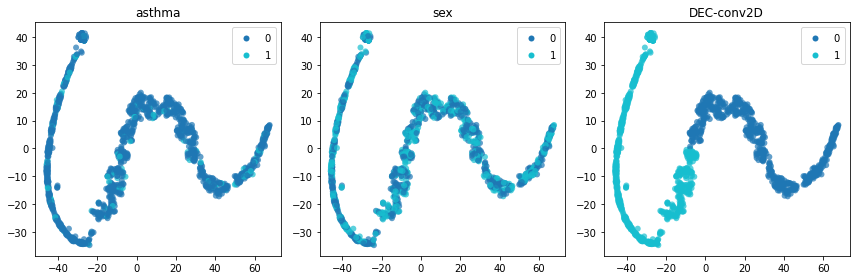

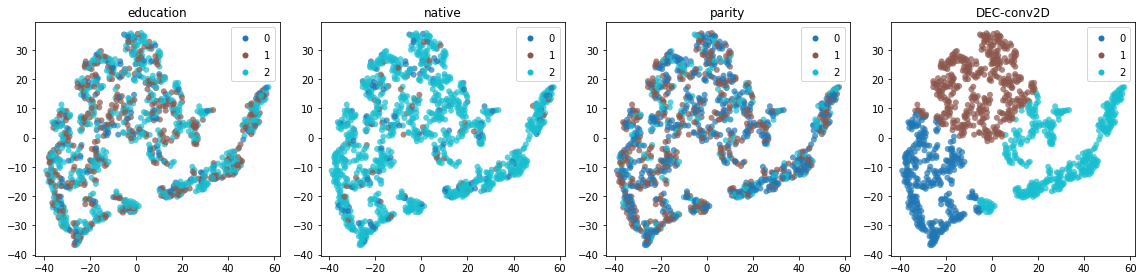

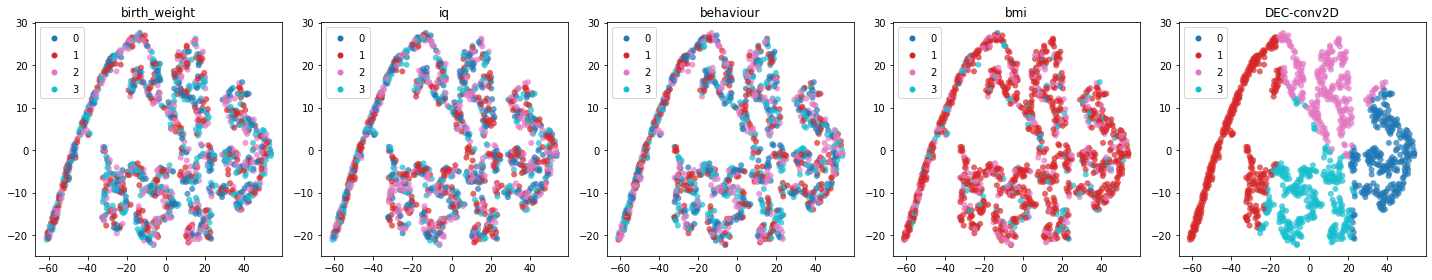

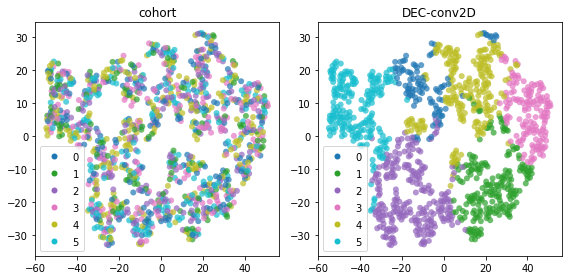

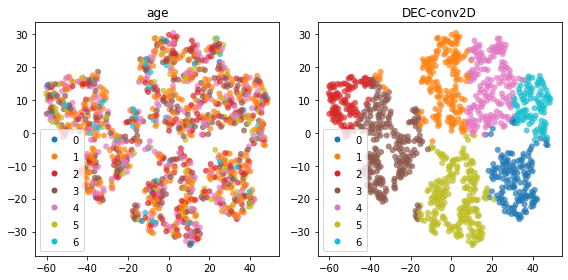

In [33]:
rl_method = "DEC-conv2D"
clust_method = "K-Means"

for k, variables in categorical_variables.items():
    LATENT_DIM = k
    N_CLUSTERS = k
    
    # Construct and pretrain AE
    print(f"K={k} - Pretraining AE", end=" ")
    encoder = get_encoder(INPUT_DIM, LATENT_DIM, FILTERS, KERNEL)
    decoder = get_decoder(INPUT_DIM, LATENT_DIM, FILTERS, KERNEL)
    z = encoder(encoder.inputs)
    ae_outputs = decoder(z)
    model_ae = models.Model(encoder.inputs, ae_outputs)
    
    optimizer = keras.optimizers.SGD(learning_rate=LEARNING_RATE_PRETRAIN,
                                     momentum=MOMENTUM_PRETRAIN)
    loss = "mse"
    model_ae.compile(optimizer=optimizer, loss=loss)
    history = model_ae.fit(metabol_exprs, metabol_exprs,
                           epochs=EPOCHS_PRETRAIN,
                           batch_size=BATCH_SIZE,
                           verbose=0)
    print(f"[loss: {history.history['loss'][-1]:.4f}]", end=" ")
    
    # Construct DEC
    print("- Fine-tunning DEC", end=" ")
    model_dec = get_dec_model(encoder, N_CLUSTERS)
    
    # Initialize parameters
    z_dec = model_dec.encode(metabol_exprs)
    kmeans = KMeans(n_clusters=N_CLUSTERS, n_init=30)
    kmeans.fit(z_dec)
    for weight in model_dec.trainable_weights:
        if weight.name == "centroids:0":
            weight.assign(K.constant(kmeans.cluster_centers_))

    p = compute_p(to_categorical(kmeans.labels_))
    c_last = kmeans.labels_

    # Fine-tune the model
    optimizer = keras.optimizers.SGD(learning_rate=LEARNING_RATE_FINETUNE, 
                                     momentum=MOMENTUM_FINETUNE)
    model_dec.compile(optimizer=optimizer)
    history = model_dec.fit(metabol_exprs, p,
                            epochs=EPOCHS_FINETUNE,
                            batch_size=BATCH_SIZE,
                            callbacks = callback,
                            verbose=0)
    print(f"[loss: {history.history['loss'][-1]:.4f}]")
    
    # Compute the cluster assignments
    c_dec = model_dec.classify(metabol_exprs)
    cluster_labels.append({"rl_method": rl_method, 
                           "clust_method": clust_method, 
                           "n_clusters": k, 
                           "labels": c_dec})
    
    # Compute metrics
    z_dec = model_dec.encode(metabol_exprs)
    for variable, labels in true_labels[k].items():
        metrics = evaluate_clustering(z_dec, labels, c_dec, False)
        print(variable, [f'{metric}: {value:.3f}' for metric, value in metrics.items()])
        result = {"rl_method": rl_method, 
                  "clust_method": clust_method, 
                  "n_clusters": k, 
                  "variable": variable}
        result.update(metrics)
        results.append(result)
    
    # Draw the embeddings
    tsne = TSNE(n_components=2, init='pca')
    z_dec_tsne = tsne.fit_transform(z_dec)

    labels = true_labels[k].copy()
    labels.update({rl_method: c_dec})
    draw_multiple_labels(z_dec_tsne, labels)

## VaDE with 2D convolutional layers

I kept getting loss=NaN when training the VaDE and I couldn't find an optimizer and learning rate that would work relliably. It didn't seem that I would get any good results any way. So I decided to take this model out of the comparison.

In [34]:
# INPUT_DIM = (16, 16, 1)
# KERNEL = 3
# FILTERS = (4, 4)

# EPOCHS_PRETRAIN = 20
# LEARNING_RATE_PRETRAIN = 0.1
# MOMENTUM_PRETRAIN = 0.5

# EPOCHS_FINETUNE = 50
# LEARNING_RATE_FINETUNE = 1e-6
# MOMENTUM_FINETUNE = 0.1

# BATCH_SIZE = 32
# SCHEDULE = 10

# callback = [tf.keras.callbacks.LearningRateScheduler(scheduler),]

In [35]:
# rl_method = "VaDE-conv2D"
# clust_method = "GMM"

# for k, variables in categorical_variables.items():
#     LATENT_DIM = k
#     N_CLUSTERS = k
    
#     # Construct and train the VaDE model.
#     # If loss == NaN: retry.
#     while True:
#         # Construct and pretrain the AE
#         print(f"K={k} - Pretraining AE", end=" ")
#         vae_encoder = get_vae_encoder(INPUT_DIM, LATENT_DIM, FILTERS, KERNEL)
#         vae_decoder = get_decoder(INPUT_DIM, LATENT_DIM, FILTERS, KERNEL)
#         model_pretrain = AutoEncoderForPretrain(vae_encoder, vae_decoder)
        
#         optimizer = keras.optimizers.SGD(learning_rate=LEARNING_RATE_PRETRAIN,
#                                          momentum=MOMENTUM_PRETRAIN)
#         loss = keras.losses.BinaryCrossentropy()
#         model_pretrain.compile(optimizer=optimizer, loss=loss)
#         history = model_pretrain.fit(metabol_exprs,
#                                      epochs=EPOCHS_PRETRAIN,
#                                      batch_size=BATCH_SIZE,
#                                      verbose=0)
#         #If loss == NaN: retry.
#         if np.isnan(history.history['loss'][-1]):
#             print("[loss:NaN. Retrying.]")
#             continue
#         else:
#             print(f"[loss: {history.history['loss'][-1]:.4f}]", end=" ")
        
#         # Construct the VaDE model
#         model_vade = VaDE(N_CLUSTERS, model_pretrain.encoder, model_pretrain.decoder)
#         # Initialize parameters
#         z_vade = model_vade.encode_only_mu(metabol_exprs)
#         gmm = GaussianMixture(n_components=N_CLUSTERS, covariance_type='diag', n_init=30)
#         gmm.fit(z_vade)
#         for weight in model_vade.trainable_weights:
#             if weight.name == "pi:0":
#                 weight.assign(K.log(K.constant(gmm.weights_)))
#             elif weight.name == "mu:0":
#                 weight.assign(K.constant(gmm.means_))
#             elif weight.name == "logvar:0":
#                 weight.assign(K.log(K.constant(gmm.covariances_)))

#         # Fine-tune the model
#         print("- Fine-tunning VaDE", end=" ")
#         optimizer = keras.optimizers.SGD(learning_rate=LEARNING_RATE_FINETUNE,
#                                          momentum=MOMENTUM_FINETUNE)
#         model_vade.compile(optimizer=optimizer)
#         history = model_vade.fit(metabol_exprs,
#                                  epochs=EPOCHS_FINETUNE,
#                                  batch_size=BATCH_SIZE,
#                                  callbacks = callback,
#                                  verbose=0)
#         #If loss == NaN: retry.
#         if np.isnan(history.history['loss'][-1]):
#             print("[loss:NaN. Retrying.]")
#             continue
#         else:
#             print(f"[loss: {history.history['loss'][-1]:.4f}]")
#             break

#     # Compute the cluster assignments
#     c_vade = model_vade.classify(metabol_exprs).numpy()
#     cluster_labels.append({"rl_method": rl_method, 
#                            "clust_method": clust_method, 
#                            "n_clusters": k, 
#                            "labels": c_vade})
    
#     # Compute metrics
#     z_vade = model_vade.encode_only_mu(metabol_exprs)
#     for variable, labels in true_labels[k].items():
#         metrics = evaluate_clustering(z_vade, labels, c_vade, False)
#         print(variable, [f'{metric}: {value:.3f}' for metric, value in metrics.items()])
#         result = {"rl_method": rl_method, 
#                   "clust_method": clust_method, 
#                   "n_clusters": k, 
#                   "variable": variable}
#         result.update(metrics)
#         results.append(result)
    
#     # Draw the embeddings
#     tsne = TSNE(n_components=2, init='pca')
#     z_vade_tsne = tsne.fit_transform(z_vade)

#     labels = true_labels[k].copy()
#     labels.update({rl_method: c_vade})
#     draw_multiple_labels(z_vade_tsne, labels)

# Results

## Metrics

In [36]:
results = pd.DataFrame(results)
# Save the metrics on a CSV file
results.to_csv("results/metrics_deepclust_conv.csv", index=False)

results_mean = results.set_index(["rl_method","clust_method"]).groupby(level=[0,1]).mean()
results_mean = results_mean.iloc[:,1:]
results_mean.style.background_gradient(axis=0, cmap="cividis", text_color_threshold=0.3, subset=['Acc','ARI','AMI','Sil']).format('{:.2f}', subset=['Acc','ARI','AMI','Sil'])

In [37]:
results.style.background_gradient(axis=0, cmap="cividis", text_color_threshold=0.3, subset=['Acc','ARI','AMI','Sil']).format('{:.2f}', subset=['Acc','ARI','AMI','Sil'])

There is no match between any of the clusters found and the categorical data. The high accuracy values on the variables "asthma" and "native" are due to there being a groups which contains the majority of the observations, so a random assignment would also get a high accuracy.

## Compare assignments

In [38]:
cluster_labels = pd.DataFrame(cluster_labels)

# Save the assignments on a CSV file
pd.DataFrame(cluster_labels).to_csv("results/assign_deepclust_conv.csv", index=False)

DEC-conv1D vs DEC-conv2D - K=2 ['Acc: 0.916', 'ARI: 0.691', 'AMI: 0.597', 'Sil: 0.346']
DEC-conv1D vs VaDE-conv1D - K=2 ['Acc: 0.859', 'ARI: 0.513', 'AMI: 0.519', 'Sil: 0.358']
DEC-conv1D vs DEC-conv2D - K=3 ['Acc: 0.817', 'ARI: 0.530', 'AMI: 0.466', 'Sil: 0.152']
DEC-conv1D vs VaDE-conv1D - K=3 ['Acc: 0.794', 'ARI: 0.490', 'AMI: 0.477', 'Sil: 0.148']
DEC-conv1D vs DEC-conv2D - K=4 ['Acc: 0.786', 'ARI: 0.528', 'AMI: 0.514', 'Sil: 0.144']
DEC-conv1D vs VaDE-conv1D - K=4 ['Acc: 0.581', 'ARI: 0.244', 'AMI: 0.285', 'Sil: -0.011']
DEC-conv1D vs DEC-conv2D - K=6 ['Acc: 0.646', 'ARI: 0.382', 'AMI: 0.432', 'Sil: 0.054']
DEC-conv1D vs VaDE-conv1D - K=6 ['Acc: 0.516', 'ARI: 0.295', 'AMI: 0.359', 'Sil: 0.017']
DEC-conv1D vs DEC-conv2D - K=7 ['Acc: 0.505', 'ARI: 0.292', 'AMI: 0.370', 'Sil: -0.000']
DEC-conv1D vs VaDE-conv1D - K=7 ['Acc: 0.602', 'ARI: 0.349', 'AMI: 0.413', 'Sil: 0.089']


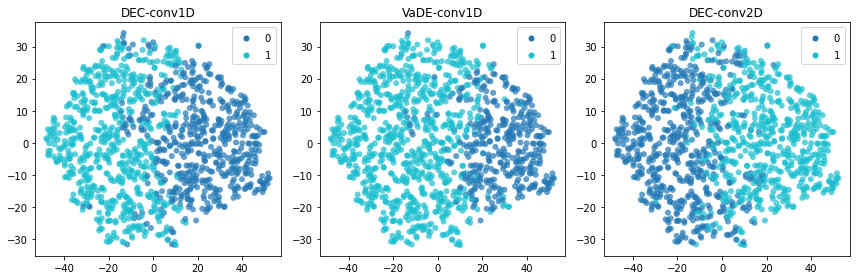

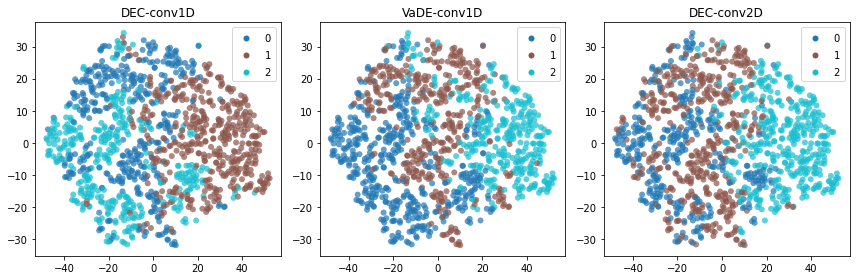

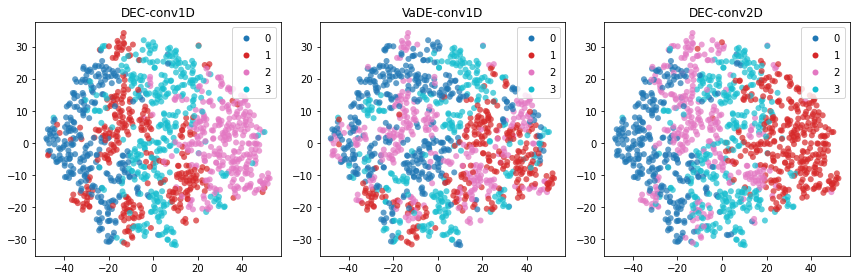

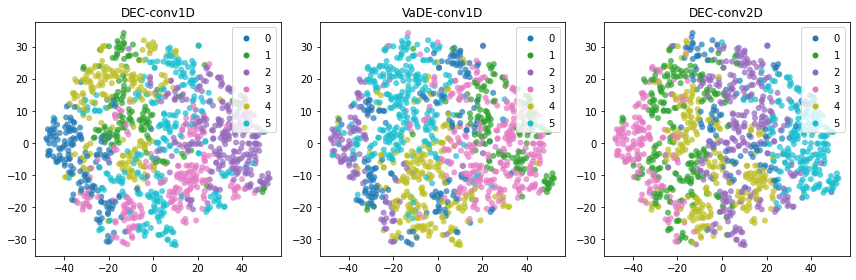

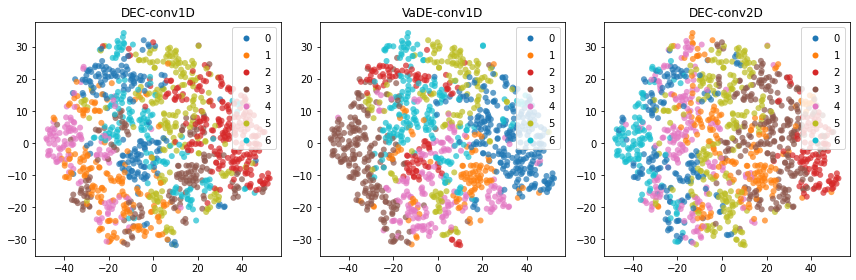

In [39]:
for k in categorical_variables.keys():
    clusters = cluster_labels[cluster_labels.n_clusters==k]
    labels = {clusters.rl_method[i]: clusters.labels[i] for i in clusters.index}
    draw_multiple_labels(z_vade_tsne, labels, max_cols=6)
    
    metrics = evaluate_clustering(z_vade_tsne, labels["DEC-conv1D"], labels["DEC-conv2D"], False)
    print(f'DEC-conv1D vs DEC-conv2D - K={k}', [f'{metric}: {value:.3f}' for metric, value in metrics.items()])
    
    # metrics = evaluate_clustering(z_vade_tsne, labels["VaDE-conv1D"], labels["VaDE-conv2D"], False)
    # print(f'VaDE-conv1D vs VaDE-conv2D - K={k}', [f'{metric}: {value:.3f}' for metric, value in metrics.items()])
    
    metrics = evaluate_clustering(z_vade_tsne, labels["DEC-conv1D"], labels["VaDE-conv1D"], False)
    print(f'DEC-conv1D vs VaDE-conv1D - K={k}', [f'{metric}: {value:.3f}' for metric, value in metrics.items()])
    
    # metrics = evaluate_clustering(z_vade_tsne, labels["DEC-conv2D"], labels["VaDE-conv2D"], False)
    # print(f'DEC-conv2D vs VaDE-conv2D - K={k}', [f'{metric}: {value:.3f}' for metric, value in metrics.items()])

There is a high convergence of the clusters found with 2 and 3 groups. For 4 and more groups, the two DEC models assignments match better than the DEC and VaDE. But in all the cases, there is no clear correlation between the cluster assignments and the categorical variables explored.